In [1]:
#several of these things are probably non necessary but anyway...
import numpy as np
from qutip import *
from inspect import getfullargspec
import cmath
from scipy.optimize import curve_fit
from lmfit import *
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
from numpy import concatenate, real, std, abs
from numpy.fft import ifft, fftfreq
from numpy.random import normal
from matplotlib import *
from pylab import *
import scipy.integrate as integrate
from scipy.interpolate import *

In [2]:
def NoiseGenerator(lambda spectrum, int samples, double totaltime, fmin=0.):
    f = fftfreq(samples)*samples/totaltime

    s_scale = abs(concatenate([f[f<0], [f[-1]]]))
    if fmin:
        ix = sum(s_scale>fmin)
        print(ix)
        if ix < len(f):
            s_scale[ix:] = s_scale[ix]
    s_scale = np.sqrt(spectrum(s_scale)*samples/totaltime)    
    sr = s_scale * normal(size=len(s_scale))
    si = s_scale * normal(size=len(s_scale))
    if not (samples % 2): si[0] = si[0].real

    s = sr + 1J * si
    s = concatenate([s[1-(samples % 2):][::-1], s[:-1].conj()])

    y = ifft(s).real

    return y / std(y)

In [3]:
#Charge qubit in a double quantum-dot.
#State order: |L>, |R>

def H_charge(epsilon, t):
    return Qobj([[epsilon/2,t], [t,-epsilon/2]])

#Charge quadrupolar qubit
#State order: |L>, |M>, |R>

def H_cq(epsilon_A, epsilon_M, tl, tr):
    return Qobj([[epsilon_A,tl,0], [tl,epsilon_M,tr],[0,tr,-epsilon_A]])

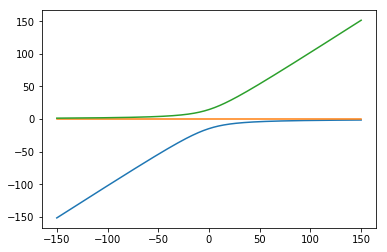

In [4]:
epslist = np.linspace(-150, 150., 300)
eiglist = []
for eps in epslist:
    eiglist.append(H_cq(0,eps,2.5*4.13,2.5*4.13).eigenenergies())
plot(epslist,eiglist)

In [5]:
#qubit energy with t in GHz and epsM in ueV. Result in ueV
#Remember, in the definitions there is a sqrt(2) factor difference between them
def cqenergy(epsA,epsM,t):
    evs=H_cq(epsA,epsM,t,t).eigenenergies()
    return evs[2]-evs[0]
def cdenergy(eps,t):
    evs=H_charge(eps,sqrt(2)*t).eigenenergies()
    return evs[1]-evs[0]

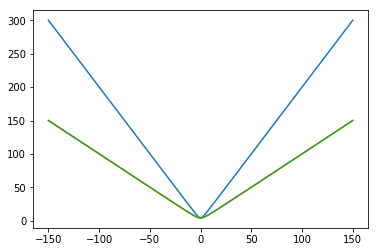

In [6]:
#Energy of cq, cd, cq as a function of epsA, epsA, epsM
#Basically, the cd curvature(epsA)=the cq curvature(epsM). The measurements show fluctuations in epsM are smaller
#However, the curvature of cq(epsA) is sharper! Following Eqs. (5) and (6) in ncomms15923 it follows that
#Curvature_cq(epsA)=4Curvature_cd(epsA) at the DFS
epslist = np.linspace(-150, 150., 300)
eiglist = []
for eps in epslist:
    eiglist.append(cqenergy(eps,0,1.5))
plot(epslist,eiglist)
eiglist = []
for eps in epslist:
    eiglist.append(cdenergy(eps,1.5))
plot(epslist,eiglist)
eiglist = []
for eps in epslist:
    eiglist.append(cqenergy(0,eps,1.5))
plot(epslist,eiglist)

In [7]:
#fitter can be used to fit numerical to a modelfunction
def fitter(datax, datay, modelfunction, initial_values):
    parameters=getfullargspec(modelfunction).args
    parameters.remove('x')
    plist=list(range(0,len(parameters)))
    model = Model(modelfunction, independent_vars='x')
    params = Parameters()
    for pn in plist:
        params.add(parameters[pn],value = initial_values[pn], min=0)
    result = model.fit(datay, params, x=datax)
    return result.params[parameters[0]].value

In [8]:
#fitterplot does the same but it plots the results
def fitterplot(datax, datay, modelfunction, initial_values):
    parameters=getfullargspec(modelfunction).args
    parameters.remove('x')
    plist=list(range(0,len(parameters)))
    model = Model(modelfunction, independent_vars='x')
    params = Parameters()
    for pn in plist:
        params.add(parameters[pn],value = initial_values[pn], min=0)    
    result = model.fit(datay, params, x=datax)
    print(result.fit_report())
    plt.plot(datax, datay, 'bo')
    plt.plot(datax, result.best_fit, 'r-')
    plt.show()
    return result.params[parameters[0]].value

# Non-perturbative detuning noise

In [9]:
#These are all the decoherence channels that I have considered for this 3 level system
#The GellMannProjector gets a noise Hamiltonian and gets the coefficients of each decoherence channel
#Note that, as long as we only consider fluctuations of dipolar detuning at the DFS, only the leakage terms are present
grelax = Qobj([[0,1,0],[1,0,0],[0,0,0]])
gdephasing = Qobj([[1,0,0],[0,-1,0],[0,0,0]])
gleakage02 = Qobj([[0,0,1],[0,0,0],[1,0,0]])
gleakage12 = Qobj([[0,0,0],[0,0,1],[0,1,0]])
def GellMannProjector(operator):
    return ((1/2 * (operator * gdephasing).tr()), (1/2 * (operator * grelax).tr()), (1/2 * (operator * gleakage02).tr()), (1/2 * (operator * gleakage12).tr()))
def PauliProjector(operator):
    return ((1/2 * (operator * sigmax()).tr()), (1/2 * (operator * sigmaz()).tr()))

In [10]:
#Calculating the charge-quadrupole Hamiltonian at the working point
#Output in GHz
def H3Q(epsA, epsM, t):
    evals = H_cq(epsA,epsM,t,t).eigenenergies()
    return Qobj(diag((evals[2],evals[0],evals[1])))

#HflucQ gives the noise Hamiltonian at operating point for fluctuations deltaepsA, deltaepsM, deltat
#Output in GHz
def HflucQ(eps,epsM,t,deltaepsA,deltaepsM,deltat):
    evals, evecs = H_cq(eps,epsM, t,t).eigenstates()
    evalsreordered = [evals[2],evals[0],evals[1]]
    evecsreordered = [evecs[2],evecs[0],evecs[1]]
    hdet = H_cq(eps+deltaepsA,epsM+deltaepsM, t+deltat, t+deltat)
    return (hdet.transform(evecsreordered)-diag(evalsreordered))

In [11]:
#Calculating the charge-dipole Hamiltonian at the working point
#Output in GHz
def H2D(eps, t):
    evals = H_charge(eps,t).eigenenergies()
    return Qobj(diag((evals[1],evals[0])))

#HflucD gives the noise Hamiltonian at operating point for fluctuations deltaepsA, deltaepsM, deltat
#Output in GHz

def HflucD(eps,t,deltaepsA,deltat):
    evals, evecs = H_charge(eps,t).eigenstates()
    evalsreordered = [evals[1],evals[0]]
    evecsreordered = [evecs[1],evecs[0]]
    hdet = H_charge(eps+deltaepsA,(t+deltat))
    return (hdet.transform(evecsreordered)-diag(evalsreordered))

In [14]:
#IMPORTANT NOTE1! I have exchanged left and right dipolar qubits in general compared to the experimental values
#The left dipolar qubit has better T2 here, while its the opposite in the experiment. Just remember that they exchanged
#SECOND IMPORTANT NOTE! REMEMBER MY 1/2Pi factor in general. The resulting T2 should be divided by 2pi
#Alternatively, you can just invert T2 to get the gamma/2pi that was reported experimentally
#Originally, I had a T2estimator for both the dipolar and quad qubits at the same time. But I separated them.
#This routine is made for the dipolar qubit. Receives det, quaddet (unnecessary here), tunnel coupling, L amplitude, R amplitude, correlation RL
#The values that give the original charge qubits are nL: 2.8 ueV, nR: 3.7 ueV (note that this corresponds to nR=2.8 in reality)
#THIRD IMPORTANT NOTE! I have noticed that we use different conventions for the definition of the dipolar detuning
#Here delta = (eps1-eps3)/2, so my amplitudes for delta should, in principle, be 1/2 of yours
from joblib import Parallel, delayed
import multiprocessing

oneoverfnoise=lambda f: 1/f
oneoverf2noise=lambda f: 1/f**2
quasistaticnoise= lambda f: exp(-10000*f**2)#Simulates a DiracDelta

def T2estimatorDZ(eps,epsM,t,nL,nR,corr):
    H0D=H2D(eps,t)
    psi0D = (basis(2,0)+basis(2,1)).unit()
    sampleSize=2000
    time=50
    n_iter = 5000
    tlist = np.linspace(0, time,sampleSize)
    def processInput(i):
        fluc_R = NoiseGenerator(oneoverfnoise,sampleSize,time)
        fluc_L = (NoiseGenerator(oneoverfnoise,sampleSize,time)*np.sqrt(1-corr**2)+fluc_R*corr)
        noisedetR=(nR*fluc_R)/4.13
        noisedetL=(nL*fluc_L)/4.13
        efe0=[]
        efe0b=[]
        efe0L=[]
        efe0bL=[]
        for te in range(0,sampleSize):
            efe0.append(PauliProjector(HflucD(eps,t,noisedetR[te],0))[0])
            efe0b.append(PauliProjector(HflucD(eps,t,noisedetR[te],0))[1])
            efe0L.append(PauliProjector(HflucD(eps,t,noisedetL[te],0))[0])
            efe0bL.append(PauliProjector(HflucD(eps,t,noisedetL[te],0))[1])
            efe0=asarray(efe0)
        efe0b=asarray(efe0b)
        efe0L=asarray(efe0L)
        efe0bL=asarray(efe0bL)
        NoisefunctionR = Cubic_Spline(tlist[0], tlist[-1], efe0)
        NoisefunctionRb = Cubic_Spline(tlist[0], tlist[-1], efe0b)
        NoisefunctionL = Cubic_Spline(tlist[0], tlist[-1], efe0L)
        NoisefunctionLb = Cubic_Spline(tlist[0], tlist[-1], efe0bL)
        def HnoiseR_coeff(t,args):
            return NoisefunctionR(t)
        def HnoiseRb_coeff(t,args):
            return NoisefunctionRb(t)
        def HnoiseL_coeff(t,args):
            return NoisefunctionL(t)
        def HnoiseLb_coeff(t,args):
            return NoisefunctionLb(t)
        HnoiseR = sigmax()
        HnoiseL = sigmax()
        HnoiseRb = sigmaz()
        HnoiseLb = sigmaz()
        HtotalL=[H0D,[HnoiseL,HnoiseL_coeff],[HnoiseLb,HnoiseLb_coeff]]
        HtotalR=[H0D,[HnoiseR,HnoiseR_coeff],[HnoiseRb,HnoiseRb_coeff]]resL = mesolve(HtotalL, psi0D, tlist, [], [], options=Odeoptions(nsteps=sampleSize))
        resR = mesolve(HtotalR, psi0D, tlist, [], [], options=Odeoptions(nsteps=sampleSize))
        efeL=[]
        efeR=[]
        for te in range(0,sampleSize):
            efeL.append(ket2dm(resL.states[te])[0,1])
            efeR.append(ket2dm(resR.states[te])[0,1])
        return (asarray(efeL), asarray(efeR))
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in range(0,n_iter))
    resultsL = asarray(results)[:,0]
    resultsR = asarray(results)[:,1]
    nl_list= abs(sum(resultsL[i] for i in range(0,n_iter))/n_iter)
    nr_list= abs(sum(resultsR[i] for i in range(0,n_iter))/n_iter)
    def decay(x,T2):
        return 1/2*(0+exp(-(x/T2)))
    return fitter(asarray(tlist),asarray(nl_list),decay,[20]),fitter(asarray(tlist),asarray(nr_list),decay,[20])

In [13]:
#This one works identically but for the charge quadrupole instead.

from joblib import Parallel, delayed
import multiprocessing

oneoverfnoise=lambda f: 1/f
oneoverf2noise=lambda f: 1/f**2
quasistaticnoise= lambda f: exp(-10000*f**2)

def T2estimatorQZ(eps,epsM,t,nL,nR,corr):
    H0Q=H3Q(eps,epsM,t)
    psi0Q = (basis(3,0)+basis(3,1)).unit()
    sampleSize=2000
    time=50
    n_iter = 5000
    tlist = np.linspace(0, time,sampleSize)
    def processInput(i):
        fluc_R = NoiseGenerator(oneoverfnoise,sampleSize,time)
        fluc_L = (NoiseGenerator(oneoverfnoise,sampleSize,time)*np.sqrt(1-corr**2)+fluc_R*corr)
        noisedetR=(nR*fluc_R)/4.13
        noisedetL=(nL*fluc_L)/4.13
        noisedetA=(noisedetL-noisedetR)/2
        noisedetC=(noisedetL+noisedetR)/2
        efe1=[]
        efe2=[]
        efe3=[]
        efe4=[]
        for te in range(0,sampleSize):
            efe1.append(GellMannProjector(HflucQ(eps,epsM,t,noisedetA[te],noisedetC[te],0))[3])
            efe2.append(GellMannProjector(HflucQ(eps,epsM,t,noisedetA[te],noisedetC[te],0))[2])
            efe3.append(GellMannProjector(HflucQ(eps,epsM,t,noisedetA[te],noisedetC[te],0))[1])
            efe4.append(GellMannProjector(HflucQ(eps,epsM,t,noisedetA[te],noisedetC[te],0))[0])
        efe1=asarray(efe1)
        efe2=asarray(efe2)
        efe3=asarray(efe3)
        efe4=asarray(efe4)
        Noisefunctionleak02 = Cubic_Spline(tlist[0], tlist[-1], efe1)
        Noisefunctionleak12 = Cubic_Spline(tlist[0], tlist[-1], efe2)
        Noisefunctionrelax = Cubic_Spline(tlist[0], tlist[-1], efe3)
        Noisefunctiondeph = Cubic_Spline(tlist[0], tlist[-1], efe4)
        def Hnoiseleak12_coeff(t,args):
            return Noisefunctionleak02(t)
        def Hnoiseleak02_coeff(t,args):
            return Noisefunctionleak12(t)
        def Hrelax_coeff(t,args):
            return Noisefunctionrelax(t)
        def Hdeph_coeff(t,args):
            return Noisefunctiondeph(t)
        Hleak12 = gleakage12
        Hleak02 = gleakage02
        Hrelax = grelax
        Hdeph = gdephasing
        HtotalQ=[H0Q,[Hleak02,Hnoiseleak02_coeff],[Hleak12,Hnoiseleak12_coeff],[Hrelax,Hrelax_coeff],[Hdeph,Hdeph_coeff]]
        resQ = mesolve(HtotalQ, psi0Q, tlist, [], [], options=Odeoptions(nsteps=sampleSize))
        efeQ=[]
        for te in range(0,sampleSize):
            efeQ.append(ket2dm(resQ.states[te])[0,1])
        return asarray(efeQ)
    num_cores = multiprocessing.cpu_count()
    results = Parallel(n_jobs=num_cores)(delayed(processInput)(i) for i in range(0,n_iter))
    nq_list= abs(sum(results[i] for i in range(0,n_iter))/n_iter)
    def decay(x,T2):
        return 1/2*(0+exp(-(x/T2)))
    return fitter(asarray(tlist),asarray(nq_list),decay,[20])

In [23]:
#Example of use with the ideal parameters. This gives the dipolar qubit T2 of right and left dot (remember that the amplitudes are inverted)
T2estimatorDZ(0,0,1.5,2.8,3.7,0.8)

(50.078776756376335, 28.64853144908947)

In [23]:
#Example of use for the quadrupolar.
T2estimatorQZ(0,0,1.5,2.8,3.7,0.8)

42.60054149040626

In [131]:
#Here I play with the amplitudes to get equivalent noise configurations
def get_amplitude(nL,nR,corr):
    sampleSize=50
    time=50
    fluc_R = NoiseGenerator(oneoverfnoise,sampleSize,time)
    fluc_L = (NoiseGenerator(oneoverfnoise,sampleSize,time)*np.sqrt(1-corr**2)+fluc_R*corr)
    noisedetR=(nR*fluc_R)
    noisedetL=(nL*fluc_L)
    noisedetA=(noisedetL-noisedetR)
    noisedetC=(noisedetL+noisedetR)
    return sqrt(np.array([sum(noisedetA**2),sum(noisedetC**2),sum(noisedetL**2),sum(noisedetR**2)])/sampleSize)

In [119]:
def get_amplitudeZ(ene,nL,nR,corr):
    fA = []
    fC = []
    fL = []
    fR = []
    for i in range(ene):
        fa, fc, fl, fr = get_amplitude(nL,nR,corr)
        fA.append(fa)
        fC.append(fc)
        fL.append(fl)
        fR.append(fr)
    fA = sum(fA)/ene
    fC = sum(fC)/ene
    fL = sum(fL)/ene
    fR = sum(fR)/ene
    return array([fA, fC, fL, fR])

In [22]:
#from this what you get is the equivalent noise amplitudes for our parameters in terms of dipolar detuning noise amplitude
#quadrupolar noise amplitude, left noise amplitude, and right noise amplitude
#remember that, due to our different detuning definitions, the first number should be multiplied by 2 for comparison
get_amplitudeZ(10000,2.8,3.7,0.8)

array([1.1455725 , 3.1893686 , 2.88312752, 3.82879817])

In [19]:
#This one is made to get noise amplitudes for each dot individually
#Of course, it is limited by the fact that we have four numbers and five equations
def get_amplitudeALT(n1,n2,n3,cLC,cRC):
    sampleSize=50
    time=50
    fluc_2 = NoiseGenerator(oneoverfnoise,sampleSize,time)
    fluc_1 = (NoiseGenerator(oneoverfnoise,sampleSize,time)*np.sqrt(1-cLC**2)+fluc_2*cLC)
    fluc_3 = (NoiseGenerator(oneoverfnoise,sampleSize,time)*np.sqrt(1-cRC**2)+fluc_2*cRC)
    noisedetR=(n3*fluc_3-n2*fluc_2)
    noisedetL=(n1*fluc_1-n2*fluc_2)
    noisedetA=(noisedetL-noisedetR)/2
    noisedetC=(noisedetL+noisedetR)/2
    return sqrt(np.array([sum(noisedetA**2),sum(noisedetC**2),sum(noisedetL**2),sum(noisedetR**2)])/sampleSize)

In [17]:
def get_amplitudeALTZ(ene,n1,n2,n3,cLC,cRC):
    fA = []
    fC = []
    fL = []
    fR = []
    for i in range(ene):
        fa, fc, fl, fr = get_amplitudeALT(n1,n2,n3,cLC,cRC)
        fA.append(fa)
        fC.append(fc)
        fL.append(fl)
        fR.append(fr)
    fA = sum(fA)/ene
    fC = sum(fC)/ene
    fL = sum(fL)/ene
    fR = sum(fR)/ene
    return array([fA, fC, fL, fR])

In [20]:
#This is the example I was able to get: left dot amplitude 1.3, center dot 3.45, right dot 1.98, cLC=0.65, cRC=0.15
#again remember that left and right dots are exchanged. The right dot should be the one with higher noise amplitude
#this combination, of course, is not unique
get_amplitudeALTZ(1000,1.3,3.45,1.98,0.65,0.15)

array([1.17006346, 3.18480349, 2.87047422, 3.83903149])